In [1]:
import pandas as pd
import numpy as np
import random as rng

# Settings

In [40]:
data_filepath = "PaintShop - September 2024.xlsx"
data_sheet_names_by_table_name = {
    "orders": "Orders", 
    "machines": "Machines", 
    "setups": "Setups"
}
rng.seed(420)

# Data

In [3]:
data = {table_name: pd.read_excel(data_filepath, sheet_name) for table_name, sheet_name in data_sheet_names_by_table_name.items()}

# We keep the soource data in a dictionary in order to prevent confusion about what tables are source and what are derived.
orders = pd.read_excel(data_filepath, sheet_name = "Orders")
machine_speeds = pd.read_excel(data_filepath, sheet_name = "Machines")
setups = pd.read_excel(data_filepath, sheet_name = "Setups")

In [4]:
data["orders"]

,Order,Surface,Colour,Deadline,Penalty
0,O1,150,Green,18,10
1,O2,200,Yellow,28,12
2,O3,180,Blue,12,8
3,O4,170,Blue,15,15
4,O5,130,Yellow,36,9
5,O6,160,Blue,33,11
6,O7,140,Green,35,14
7,O8,210,Yellow,38,13
8,O9,190,Blue,32,7
9,O10,120,Green,41,10


In [5]:
data["machines"].head()

,Machine,Speed
0,M1,20
1,M2,25
2,M3,18


In [6]:
data["setups"]

,From colour,To colour,Setup time
0,Green,Red,6
1,Yellow,Green,2
2,Green,Yellow,5
3,Yellow,Red,1
4,Red,Yellow,8
5,Red,Green,5
6,Blue,Red,8
7,Blue,Yellow,10
8,Blue,Green,4
9,Green,Blue,3


### Prepare data

In [7]:
machine_speeds = {
    id: speed 
    for id, speed 
    in zip(data["machines"].index, data["machines"]["Speed"])
}
machine_speeds

{0: 20, 1: 25, 2: 18}

In [8]:
machine_ids = data["machines"].index.values

In [9]:
# Encode color names for efficiency, set ID as index
unique_colors = data["setups"]["From colour"].unique()
color_names_by_index = pd.DataFrame({
    "name": [c_name for c_name in unique_colors]
}, index = range(len(unique_colors)))
color_names_by_index

,name
0,Green
1,Yellow
2,Red
3,Blue


In [10]:
# Encode color names in setups
setups = pd.DataFrame({
    "c1":   data["setups"]["From colour"].apply(lambda from_color: color_names_by_index[color_names_by_index["name"] == from_color].index[0]),
    "c2":   data["setups"]["To colour"  ].apply(lambda to_color:   color_names_by_index[color_names_by_index["name"] == to_color  ].index[0]),
    "time": data["setups"]["Setup time" ]
})
setups

,c1,c2,time
0,0,2,6
1,1,0,2
2,0,1,5
3,1,2,1
4,2,1,8
5,2,0,5
6,3,2,8
7,3,1,10
8,3,0,4
9,0,3,3


In [11]:
# Fix orders table: encode colors and set order index as index
orders = pd.DataFrame(
    {
        "surface": data["orders"]["Surface"].values,
        "color": [color_names_by_index[color_names_by_index["name"] == c].index[0] for c in data["orders"]["Colour"]],
        "deadline": data["orders"]["Deadline"].values,
        "penalty": data["orders"]["Penalty"].values,
    },
    index = data["orders"].index
)
orders  

,surface,color,deadline,penalty
0,150,0,18,10
1,200,1,28,12
2,180,3,12,8
3,170,3,15,15
4,130,1,36,9
5,160,3,33,11
6,140,0,35,14
7,210,1,38,13
8,190,3,32,7
9,120,0,41,10


In [12]:
def first_or_0(list):
    if len(list) == 0:
        return 0
    return list[0] 

# Create table of order-to-order setup times.
setup_times = pd.DataFrame({ 
    order1_id: pd.Series([
        0 if (order1_id == order2_id) else
        first_or_0(setups.loc[
            (setups["c1"] == orders.loc[order1_id, "color"]) &
            (setups["c2"] == orders.loc[order2_id, "color"]),
            "time"
        ].values) for order2_id in orders.index.values
    ], dtype="Int64") for order1_id in orders.index.values 
}).transpose()

# Display table
setup_times

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6
1,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
2,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
3,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
4,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
5,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
6,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6
7,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
8,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
9,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6


In [13]:
process_times = pd.DataFrame({
    machine_id: [
        order_surface / machine_speed for order_surface in orders["surface"].values
    ] for machine_id, machine_speed in machine_speeds.items()
})
process_times

,0,1,2
0,7.5,6.0,8.333333
1,10.0,8.0,11.111111
2,9.0,7.2,10.000000
3,8.5,6.8,9.444444
4,6.5,5.2,7.222222
5,8.0,6.4,8.888889
6,7.0,5.6,7.777778
7,10.5,8.4,11.666667
8,9.5,7.6,10.555556
9,6.0,4.8,6.666667


### Functions

### Classes

[[(0, 7.5, 0), (10.5, 8.5, 3), (23.0, 7.0, 0), (30.0, 6.0, 0), (36.0, 5.5, 0), (44.5, 8.0, 3), (52.5, 10.0, 3), (66.5, 6.5, 0), (73.0, 10.5, 0), (83.5, 11.5, 0)], [(0, 8.0, 1), (8.0, 5.2, 1), (13.2, 8.4, 1), (21.6, 9.2, 1), (30.8, 10.0, 1), (40.8, 5.6, 1), (46.4, 6.0, 1), (63.4, 7.2, 3), (80.6, 8.8, 1), (89.39999999999999, 4.4, 1)], [(0, 10.0, 3), (10.0, 8.88888888888889, 3), (18.88888888888889, 10.555555555555555, 3), (37.44444444444444, 12.222222222222221, 2), (49.666666666666664, 13.333333333333334, 2), (63.0, 11.666666666666666, 2), (74.66666666666667, 9.444444444444445, 2), (84.11111111111111, 10.555555555555555, 2), (98.66666666666667, 6.666666666666667, 3), (113.33333333333334, 13.333333333333334, 2)]]


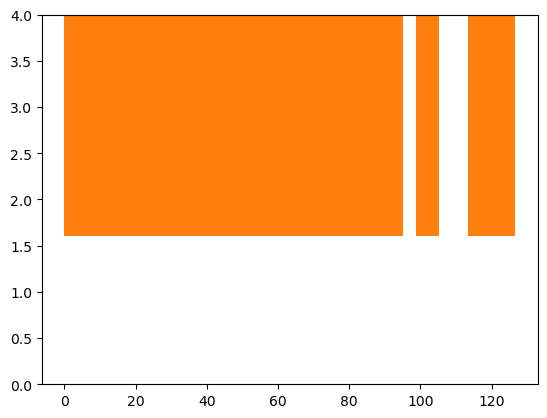

In [60]:
import copy
import matplotlib.pyplot as plt


class Schedule:
    """A class representing a solution to the paintshop-problem. This is essentially a wrapper for it's internal dict[int, list[int]] object (.order_queue) with some usefull functions.
    """
    
    
    # Constructor. Example call: "Solution()".
    def __init__(self):
        """Constructs an empty solution.
        """
        self.order_queue = {
            i: [] for i in machine_ids
        }
    
    # Index getter. Example call: "Solution()[i]".
    def __getitem__(self, machine_id: int) -> list[int]:
        """Gets the queue for the machine with the specified machine-number

        Args:
            machine_id (int): The index of the machine.

        Returns:
            list[int]: The queue for the specified machine.
        """
        return self.order_queue[machine_id]
    
    # Index setter. Example call: "Solution()[i] += [1]"
    def __setitem__(self, machine_id: int, queue: list[int]):
        """Sets the queue for the machine with the specified machine-number

        Args:
            machine_id (int): The index of the machine.
            queue (list[int]): The queue for the specified machine.
        """
        self.order_queue[machine_id] = queue
    
    # String conversion. Example call: "print(Schedule())" or "str(Schedule())"
    def __str__(self) -> str:
        
        return f"Cost: \t{self.get_cost():.2f}\n" + '\n'.join([f'M{machine_id + 1}: {self.order_queue[machine_id]} ({self.get_cost_machine(machine_id):.2f})' for machine_id in machine_ids])
    
    # def __copy__(self):
        
    #     new = Schedule()
    #     new.order_queue = self.order_queue
    #     return new
    
    
    # Returns the solution in pandas.DataFrame form
    def to_dataframe(self) -> pd.DataFrame:
        """Returns the Solution converted to a pandas.DataFrame.

        Returns:
            pd.DataFrame: The Solution in dataframe form.
        """
        
        return pd.DataFrame.from_dict(
            self.order_queue,
        ).rename(columns ={
            machine_id: f"M{machine_id + 1}" 
            for machine_id in machine_ids
        })
    
    def draw(self) -> None:
        
        # Calculate machine times
        machine_schedules = [[] for _ in machine_ids]
        for machine_id in machine_ids:
            
            t_current = 0
            last_order_id = None
            machine_schedule = []
            
            for order_id in self.order_queue[machine_id]:
                
                if (last_order_id is not None):
                    t_current += setup_times.loc[last_order_id, order_id]
                
                processing_time = orders.loc[order_id, "surface"] / machine_speeds[machine_id]
                machine_schedule += [(t_current, processing_time, orders.loc[order_id, "color"])]
                
                t_current += processing_time
                    
                last_order_id = order_id
            
            
            machine_schedules[machine_id] = machine_schedule
        
        
        # Declaring a figure "gnt"
        fig = plt.figure()
        
        # the y
        plt.ylim(0, len(machine_ids) + 1)
        # plt.xlim(0, max([schedule[-1] for schedule in machine_schedules]))
        
        # # Setting X-axis limits
        # fig.xlim(0, 160)
        
        # # Setting labels for x-axis and y-axis
        # fig.xlabel('seconds since start')
        # fig.ylabel('Processor')
        
        # # Setting ticks on y-axis
        # fig.yticks([15, 25, 35])
        # # Labelling tickes of y-axis
        # fig.xticks(['1', '2', '3'])
        
        # # Setting graph attribute
        # fig.grid(True)
        
        print(machine_schedules)
        
        # Declaring a bar in schedule
        for machine_schedule in machine_schedules:
            plt.broken_barh([(item[0], item[1]) for item in machine_schedule], (machine_id - 0.4, machine_id + 0.4), facecolors =('tab:orange'))
    
    # Return the time at which the machine with the specified ID finishes it's order queue
    def get_finish_time(self, machine_id: int) -> float:
        
        # Processing time when starting on the current order
        t = 0
        last_order_id = None
        
        # Iterate over orders in queue
        for order_id in self.order_queue[machine_id]:
            
            # Add processing time to current time
            t += process_times.loc[order_id, machine_id]
            
            # Add setup time
            if (last_order_id != None):
                t += setup_times.loc[last_order_id, order_id]
            
            # Update last order ID
            last_order_id = order_id
            
        return t
    
    def get_cost_machine(self, machine_id):
        # Processing time when starting on the current order
        t = 0
        last_order_id = None
            
        # Initialize penalty
        total_penalty = 0
            
        # Iterate over orders in queue
        for order_id in self.order_queue[machine_id]:
            
            # Add processing time to current time
            t += process_times.loc[order_id, machine_id]
            
            # Add setup time
            if (last_order_id != None):
                t += setup_times.loc[last_order_id, order_id]
            
            # Add penalty to total_cost
            if (t > orders.loc[order_id, 'deadline']):
                total_penalty += orders.loc[order_id, 'penalty'] * (t - orders.loc[order_id, 'deadline'])
            
            # Update last order ID
            last_order_id = order_id
        
        return total_penalty
    
    # Returns the total cost of the solution
    def get_cost(self) -> float:
        """Returns the total penalty for this schedule.

        Returns:
            float: The total penalty
        """
        
        # Initialize penalty
        total_penalty = 0
        
        # Iterate over machines in schedule
        for machine_id in self.order_queue.keys():
            
            total_penalty += self.get_cost_machine(machine_id)
        
        # Return total penalty
        return total_penalty
    
    
    # Returns a list of tuples containing the swaps
    def get_swaps(self) -> list[(tuple[int, int], tuple[int, int])]:
        
        # Get all indices of the orders.
        order_indices = [(machine_id, queue_index) for machine_id in machine_ids for queue_index in range(len(self.order_queue[machine_id]))]
        
        # Return all combinations of length 2.
        return list(iter.combinations(order_indices, 2))
    
    # Get item
    def get_item(self, index: tuple[int, int]):
        
        return self.order_queue[index[0]][index[1]]
    
    # Set item
    def set_item(self, index, value):
        self.order_queue[index[0]][index[1]] = value
    
    # Swap inplace
    def swap(self, swap) -> None:
        
        (a_index, b_index) = swap
        
        a = self.get_item(a_index)
        self.set_item(a_index, self.get_item(b_index))
        self.set_item(b_index, a)
    
    # Return a swapped copy of self
    def get_swapped(self, swap: tuple[tuple[int, int], tuple[int, int]]):
        
        # print(self)
        
        # new = self.copy()
        new = copy.deepcopy(self)
        new.swap(swap)
        
        # print(new)
        # print(self)
        
        return new
    
    
heuristic_constructive_simple().draw()

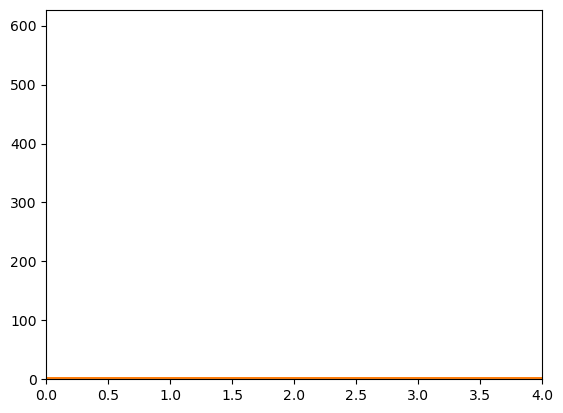

# Solution

In [15]:
def heuristic_constructive_simple() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in orders.index.values:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                len(schedule[i]) +
                i / len(machine_speeds)
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [16]:
def heuristic_constructive_simple_2() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in orders.index.values:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(machine_speeds), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [17]:
def heuristic_constructive_simple_3() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in sorted(orders.index.values, key = lambda order_id: orders.loc[order_id, 'deadline']):
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(machine_speeds), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [18]:
def heuristic_constructive_random() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    order_ids_remaining = orders.index.values
    
    while len(order_ids_remaining) > 0:
        
        next_order_id_index = rng.choice(range(len(order_ids_remaining)))
        
        schedule[rng.choice(machine_ids)] += [order_ids_remaining[next_order_id_index]]
        
        order_ids_remaining = np.delete(order_ids_remaining, next_order_id_index)      
    return schedule

In [36]:
import math


def heuristic_improvement_best(initial: Schedule) -> Schedule:
    
    current_schedule = initial
    
    print(f"Initial:")
    print(str(current_schedule) + "\n")
    
    while True:
    
        best_swap = None
        best_swap_cost = initial.get_cost()
        
        for swap in current_schedule.get_swaps():
            swapped_schedule: Schedule = current_schedule.get_swapped(swap)
            swapped_cost = swapped_schedule.get_cost()
            
            # print(f"Swap: {swap}, Cost: {swapped_cost}")
            
            if (swapped_cost < best_swap_cost):
                best_swap = swap
                best_swap_cost = swapped_cost
        
        # Break the loop if no improving swap was found.
        if best_swap == None:
            break
        
        current_schedule.swap(best_swap)
        print(f"Swapped: {best_swap}.")
        print(str(current_schedule) + "\n")
        
    return current_schedule

In [ ]:
def heuristic_improvement_first(initial: Schedule) -> Schedule:
    
    current_schedule = initial
    
    print(f"Initial:")
    print(str(current_schedule) + "\n")
    
    while True:
    
        first_improvement = None
        initial_swap_cost = initial.get_cost()
        
        for swap in current_schedule.get_swaps():
            swapped_schedule: Schedule = current_schedule.get_swapped(swap)
            swapped_cost = swapped_schedule.get_cost()
            
            # print(f"Swap: {swap}, Cost: {swapped_cost}")
            # 
            if (swapped_cost < initial_swap_cost):
                first_improvement = swap
                break
        
        # Break the loop if no improving swap was found.
        if first_improvement == None:
            break
        
        current_schedule.swap(first_improvement)
        print(f"Swapped: {first_improvement}.")
        print(str(current_schedule) + "\n")
        
    return current_schedule

In [39]:
heuristic_improvement_best(heuristic_constructive_random())

Initial:
Cost: 	9190.69
M1: [27, 5, 11, 14, 20, 17, 18, 26, 12, 15, 19, 9, 25, 29, 6] (6513.00)
M2: [3, 28, 24, 2, 4, 8, 1, 21, 22] (1766.80)
M3: [13, 7, 0, 23, 16, 10] (910.89)

Swapped: ((0, 0), (0, 14)).
Cost: 	7334.19
M1: [6, 5, 11, 14, 20, 17, 18, 26, 12, 15, 19, 9, 25, 29, 27] (4656.50)
M2: [3, 28, 24, 2, 4, 8, 1, 21, 22] (1766.80)
M3: [13, 7, 0, 23, 16, 10] (910.89)

Swapped: ((0, 11), (1, 1)).
Cost: 	5954.69
M1: [6, 5, 11, 14, 20, 17, 18, 26, 12, 15, 19, 28, 25, 29, 27] (3695.00)
M2: [3, 9, 24, 2, 4, 8, 1, 21, 22] (1348.80)
M3: [13, 7, 0, 23, 16, 10] (910.89)

Swapped: ((0, 1), (1, 4)).
Cost: 	4809.39
M1: [6, 4, 11, 14, 20, 17, 18, 26, 12, 15, 19, 28, 25, 29, 27] (3065.50)
M2: [3, 9, 24, 2, 5, 8, 1, 21, 22] (833.00)
M3: [13, 7, 0, 23, 16, 10] (910.89)

Swapped: ((0, 9), (1, 7)).
Cost: 	4302.19
M1: [6, 4, 11, 14, 20, 17, 18, 26, 12, 21, 19, 28, 25, 29, 27] (2393.50)
M2: [3, 9, 24, 2, 5, 8, 1, 15, 22] (997.80)
M3: [13, 7, 0, 23, 16, 10] (910.89)

Swapped: ((0, 12), (2, 3)).
Cost:

In [21]:
print('\n\n'.join([
    f"{schedule}" for heuristic, schedule in {
        "constructive_simple": heuristic_constructive_simple(),
        "constructive_simple_2": heuristic_constructive_simple_2(),
        "constructive_simple_3": heuristic_constructive_simple_3(),
        "constructive_random": heuristic_constructive_random()
    }.items()
]))

Cost: 	1414.11
M1: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27] (565.00)
M2: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28] (222.00)
M3: [2, 5, 8, 11, 14, 17, 20, 23, 26, 29] (627.11)

Cost: 	2815.77
M1: [0, 3, 7, 12, 14, 17, 20, 22, 25, 29] (760.50)
M2: [1, 4, 6, 9, 10, 13, 15, 19, 21, 24, 26, 28] (1440.60)
M3: [2, 5, 8, 11, 16, 18, 23, 27] (614.67)

Cost: 	4181.39
M1: [2, 10, 6, 7, 13, 19, 18, 16, 28, 23] (1632.50)
M2: [3, 11, 8, 4, 12, 15, 14, 26, 25, 21, 29] (1445.00)
M3: [0, 1, 5, 9, 24, 20, 17, 27, 22] (1103.89)

Cost: 	9128.96
M1: [14, 4, 27, 1, 28, 12, 21, 26, 17] (817.00)
M2: [2, 9, 24, 0, 23, 13, 15, 10] (1380.40)
M3: [20, 3, 16, 6, 22, 29, 18, 5, 11, 7, 19, 8, 25] (6931.56)


In [22]:
# import matplotlib.pyplot as plt

# plt.hist([s.get_cost() for s in random_schedules], bins = 30)
# plt.show()

NameError: name 'random_schedules' is not defined

In [23]:
import itertools as iter

sol = heuristic_constructive_simple()

# Gett

In [21]:
a = heuristic_constructive_simple()
a.get_swapped(((0,1), (1,6)))

Cost: 	1414.11
M1: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27] (565.00)
M2: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28] (222.00)
M3: [2, 5, 8, 11, 14, 17, 20, 23, 26, 29] (627.11)


NameError: name 'copy' is not defined